In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [54]:
tracks = pd.read_parquet('../data/tracks.parquet')
interactions = pd.read_parquet('../data/interactions.parquet')
catalog = pd.read_parquet('../data/catalog_names.parquet')

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [55]:
tracks.head()

track_id                                             albums artists  \
0        26                                       [3, 2490753]    [16]   
1        38                                       [3, 2490753]    [16]   
2       135                                 [12, 214, 2490809]    [84]   
3       136                                 [12, 214, 2490809]    [84]   
4       138  [12, 214, 322, 72275, 72292, 91199, 213505, 24...    [84]   

     genres                                 name  count  
0  [11, 21]                     Complimentary Me      5  
1  [11, 21]                          Momma's Boy      8  
2      [11]                              Atticus     16  
3      [11]                             24 Hours      7  
4      [11]  Don't Upset The Rhythm (Go Baby Go)     17

In [6]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932664 entries, 0 to 932663
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   track_id  932664 non-null  int64 
 1   albums    932664 non-null  object
 2   artists   932664 non-null  object
 3   genres    932664 non-null  object
 4   name      932664 non-null  object
 5   count     932664 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 42.7+ MB


In [7]:
tracks['empty_genre'] = tracks['genres'].apply(lambda data: len(data) == 0)
tracks['empty_album'] = tracks['albums'].apply(lambda data: len(data) == 0)
tracks['empty_artist'] = tracks['artists'].apply(lambda data: len(data) == 0)

In [8]:
tracks = tracks.loc[~tracks['empty_artist']]
tracks = tracks.loc[~tracks['empty_album']]
tracks = tracks.loc[~tracks['empty_genre']]
len(tracks)

932664

In [56]:
catalog.head()

id   type               name
0   3  album    Taller Children
1  12  album  Wild Young Hearts
2  13  album      Lonesome Crow
3  17  album      Graffiti Soul
4  26  album     Blues Six Pack

In [57]:
catalog.type.unique()

array(['album', 'artist', 'genre', 'track'], dtype=object)

In [9]:
catalog.loc[(catalog.type == 'track') & (catalog.id == 38012 )]

id   type        name
819116  38012  track  The Riddle

In [10]:
genre_list = catalog.loc[catalog.type=='genre', 'id'].values
print(len(genre_list))
album_list = catalog.loc[catalog.type=='album', 'id'].values
print(len(album_list))
artist_list = catalog.loc[catalog.type=='artist', 'id'].values
print(len(artist_list))

166
658724
153581


Проверяем, есть ли неизвестные данные в столбцах (которых нет в каталоге)

In [15]:
tracks['unknown_genre'] = tracks['genres'].apply(lambda alb: sum([1 if a in genre_list else 0 for a in alb]) / len(alb))
tracks.query('unknown_genre < 1')

Empty DataFrame
Columns: [track_id, albums, artists, genres, name, count, empty_genre, empty_album, empty_artist, unknown_genre, unknown_artist, unknown_album]
Index: []

In [13]:
tracks['unknown_artist'] = tracks['artists'].apply(lambda alb: sum([1 if a in artist_list else 0 for a in alb]) / len(alb))
tracks.query('unknown_artist < 1')

Empty DataFrame
Columns: [track_id, albums, artists, genres, name, count, empty_genre, empty_album, empty_artist, unknown_genre, unknown_artist]
Index: []

In [14]:
# 10 minutes
tracks['unknown_album'] = tracks['albums'].apply(lambda alb: sum([1 if a in album_list else 0 for a in alb]) / len(alb))
tracks.query('unknown_album < 1')

Empty DataFrame
Columns: [track_id, albums, artists, genres, name, count, empty_genre, empty_album, empty_artist, unknown_genre, unknown_artist, unknown_album]
Index: []

In [16]:
tracks = tracks.loc[tracks['unknown_genre'] == 1]

In [17]:
track_list = tracks.track_id.unique()

In [18]:
interactions.info()
interactions.nunique()

<class 'pandas.core.frame.DataFrame'>
Index: 214714415 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.2 GB


user_id       1368700
track_id       932664
track_seq       16636
started_at        365
dtype: int64

In [19]:
interactions = interactions.loc[interactions['track_id'].isin(track_list)]


In [20]:
interactions.info()
interactions.nunique()

<class 'pandas.core.frame.DataFrame'>
Index: 214714415 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.2 GB


user_id       1368700
track_id       932664
track_seq       16636
started_at        365
dtype: int64

In [21]:
def flat_index(df_stats): 
    df_stats.columns = df_stats.columns.get_level_values(0) + '_' +  df_stats.columns.get_level_values(1) 
    df_stats.columns.to_flat_index() 
    df_stats.columns = df_stats.columns.to_flat_index() 
    df_stats.reset_index(inplace=True) 
    return df_stats

In [22]:
numeric_cols = interactions.select_dtypes(include=['int16','int32']).columns.tolist()
numeric_cols

['user_id', 'track_id', 'track_seq']

In [23]:
users_grouped = interactions[numeric_cols].groupby('user_id').agg(['count', 'sum', 'max'])
users_grouped = flat_index(users_grouped)

In [27]:
users_grouped

user_id  track_id_count  track_id_sum  track_id_max  track_seq_count  \
0              0              26     222329191      20497621               26   
1              1              36    1433967998      83436771               36   
2              2              13     382479927      71650200               13   
3              3              33    1437092275      78194999               33   
4              4             245    8570567142      98766295              245   
...          ...             ...           ...           ...              ...   
1368695  1374578              11     360121964      35785893               11   
1368696  1374579              23     178064881      41899516               23   
1368697  1374580             274   10513244081      96618101              274   
1368698  1374581             503   21329665736      99242432              503   
1368699  1374582             290   17626701721     100736375              290   

         track_seq_sum  track_seq_max  
0                  351             26  
1                  666             36  
2                  103             14  
3                  561             33  
4                31738            256  
...                ...            ...  
1368695             66             11  
1368696            289             24  
1368697          37911            277  
1368698         126756            503  
1368699          42717            292  

[1368700 rows x 7 columns]

In [28]:
tracks_grouped = interactions[numeric_cols].groupby('track_id').agg(['count','sum','max'])
tracks_grouped = flat_index(tracks_grouped)
tracks_grouped

track_id  user_id_count  user_id_sum  user_id_max  track_seq_count  \
0              26              5      3187389      1008720                5   
1              38              8      6510921      1304168                8   
2             135             16     11203352      1324586               16   
3             136              7      5253974      1203184                7   
4             138             17     15656791      1324586               17   
...           ...            ...          ...          ...              ...   
932659  101478482              6      2809606      1055764                6   
932660  101490148             72     44514110      1322150               72   
932661  101493057              9      6855759      1294431                9   
932662  101495927             20     15485868      1320566               20   
932663  101521819             34     24517206      1350411               34   

        track_seq_sum  track_seq_max  
0                   5              1  
1                   9              2  
2                  16              1  
3                  10              2  
4                  25              3  
...               ...            ...  
932659           5549           4910  
932660          38987           4911  
932661          11969           4912  
932662           9718           1146  
932663          19324           2768  

[932664 rows x 7 columns]

Найдем пользователей с малой историей - для них нет смысла считать персональные рекомендации. 

In [30]:
small_users = users_grouped.query('track_id_count <= 3')['user_id'] # пользователи, прослушавшие менее 3 треков
interactions = interactions.loc[~interactions['user_id'].isin(small_users)]


In [62]:
len(interactions.track_id.unique())

932664

In [35]:
catalog_tracks = catalog.loc[catalog.type=='track'][['id', 'name']]
catalog_tracks.to_parquet('../data/catalog_tracks.parquet')
catalog_tracks


id                                 name
812471          26                     Complimentary Me
812472          38                          Momma's Boy
812473         135                              Atticus
812474         136                             24 Hours
812475         138  Don't Upset The Rhythm (Go Baby Go)
...            ...                                  ...
1812466  101478482                              На лицо
1812467  101490148                      Без капли мысли
1812468  101493057                             SKITTLES
1812469  101495927                               Москва
1812470  101521819                               Вокзал

[1000000 rows x 2 columns]

In [ ]:
catalog_genres = catalog.loc[catalog.type=='genre'][['id', 'name']]
catalog_genres.to_parquet('../data/catalog_genres.parquet')
catalog_genres

id          name
812305     0           all
812306     1       eastern
812307     2       rusrock
812308     3        rusrap
812309     4      postrock
...      ...           ...
812466  1182        balkan
812467  1197  experimental
812468  1370       europop
812469  1484    meditation
812470  1542       asiapop

[166 rows x 2 columns]

In [33]:
catalog_albums = catalog.loc[catalog.type=='album'][['id', 'name']]
catalog_albums.to_parquet('../data/catalog_albums.parquet')
catalog_albums

id                                     name
0              3                          Taller Children
1             12                        Wild Young Hearts
2             13                            Lonesome Crow
3             17                            Graffiti Soul
4             26                           Blues Six Pack
...          ...                                      ...
658719  21458141                         The Lazy Singles
658720  21458207                  Jackie Mittoo Anthology
658721  21458968  Master Composers: Johann Sebastian Bach
658722  21459622                   Take the Money and Run
658723  21461648                                 Tropical

[658724 rows x 2 columns]

In [26]:
catalog_artists = catalog.loc[catalog.type=='artist'][['id', 'name']]
catalog_artists.to_parquet('data/catalog_artists.parquet')
catalog_artists

id           name
658724         4   Kenny Dorham
658725         5      Max Roach
658726         7  Francis Rossi
658727         9     Status Quo
658728        12    Phil Everly
...          ...            ...
812300  16093680  Los Tiburones
812301  16097398          AMELI
812302  16098445       2GANGSTA
812303  16099125          Daria
812304  16102782    Pan dö Baré

[153581 rows x 2 columns]

## Анализ каталогов
## Genres

In [29]:
catalog_genres

id          name
812305     0           all
812306     1       eastern
812307     2       rusrock
812308     3        rusrap
812309     4      postrock
...      ...           ...
812466  1182        balkan
812467  1197  experimental
812468  1370       europop
812469  1484    meditation
812470  1542       asiapop

[166 rows x 2 columns]

In [30]:
genres_dict = dict(zip(catalog_genres['id'], [0]*catalog.shape[0]))

for k,v in tracks.iterrows():
    genres = v['genres']
    for g in genres:
        genres_dict[g] += 1
genres_df = pd.DataFrame.from_dict(genres_dict, orient='index')

In [31]:
genres_df.reset_index(inplace=True)
genres_df.columns=['id','count']
genres_df['name'] = genres_df['id'].apply(lambda x: catalog_genres.loc[catalog_genres['id'] == x]['name'].values[0] )
genres_df

id  count          name
0       0      0           all
1       1   1186       eastern
2       2  36649       rusrock
3       3  65958        rusrap
4       4   2054      postrock
..    ...    ...           ...
161  1182    454        balkan
162  1197   1674  experimental
163  1370      0       europop
164  1484   1606    meditation
165  1542    176       asiapop

[166 rows x 3 columns]

In [32]:
catalog_genres = catalog_genres.merge(genres_df[['count','id']], on='id')
catalog_genres.to_parquet('data/catalog_genres.parquet')

## Tracks

In [33]:
tracks_dict = dict(zip(catalog_tracks['id'], [0]*catalog_tracks.shape[0]))
tracks = tracks.merge(catalog_tracks, left_on='track_id', right_on='id')
tracks = tracks.merge(tracks_grouped, on='track_id')
tracks = tracks[['track_id', 'albums', 'artists', 'genres', 'name_x',  'user_id_count']]
tracks.rename(columns={'user_id_count':'count'}, inplace=True)
tracks.rename(columns={'name_x':'name'}, inplace=True)

In [35]:
tracks

track_id                                             albums  \
0              26                                       [3, 2490753]   
1              38                                       [3, 2490753]   
2             135                                 [12, 214, 2490809]   
3             136                                 [12, 214, 2490809]   
4             138  [12, 214, 322, 72275, 72292, 91199, 213505, 24...   
...           ...                                                ...   
932659  101478482                                         [21399811]   
932660  101490148                                         [21403052]   
932661  101493057                                         [21403883]   
932662  101495927                                         [21404975]   
932663  101521819                                         [21414638]   

           artists    genres                                 name  count  
0             [16]  [11, 21]                     Complimentary Me      5  
1             [16]  [11, 21]                          Momma's Boy      8  
2             [84]      [11]                              Atticus     16  
3             [84]      [11]                             24 Hours      7  
4             [84]      [11]  Don't Upset The Rhythm (Go Baby Go)     17  
...            ...       ...                                  ...    ...  
932659   [5540395]   [3, 75]                              На лицо      6  
932660   [9078726]  [11, 20]                      Без капли мысли     72  
932661  [11865715]  [44, 75]                             SKITTLES      9  
932662   [4462686]   [3, 75]                               Москва     20  
932663   [5056591]   [3, 75]                               Вокзал     34  

[932664 rows x 6 columns]

## Artists

In [36]:
artists_dict = dict(zip(catalog_artists['id'], [0]*catalog_artists.shape[0]))

for k,v in tracks.iterrows():
    artists = v['artists']
    for g in artists:
        artists_dict[g] += 1
artists_df = pd.DataFrame.from_dict(artists_dict, orient='index')

In [37]:
artists_df.reset_index(inplace=True)
artists_df.columns=['id','count']
artists_df['name'] = artists_df['id'].apply(lambda x: catalog_artists.loc[catalog_artists['id'] == x]['name'].values[0] )
artists_df

id  count           name
0              4      1   Kenny Dorham
1              5      1      Max Roach
2              7      1  Francis Rossi
3              9    182     Status Quo
4             12      1    Phil Everly
...          ...    ...            ...
153576  16093680      4  Los Tiburones
153577  16097398      2          AMELI
153578  16098445      1       2GANGSTA
153579  16099125      1          Daria
153580  16102782      1    Pan dö Baré

[153581 rows x 3 columns]

In [38]:
artists_df.sort_values(by='count', ascending=False).head(10)

id  count                       name
13930  118708   2038          Владимир Высоцкий
26        171   1363                    сборник
15138  139896   1273           Armin van Buuren
2096     9170   1201   Wolfgang  Amadeus Mozart
329      1227   1101    Johann  Sebastian  Bach
2570    11818   1045                Hans Zimmer
411      1551   1030  Pyotr Ilyich  Tchaikovsky
2426    10987    973              Elvis Presley
18025  188963    966                   Аквариум
16706  164416    919         Михаил Шуфутинский

In [39]:
catalog_artists = catalog_artists.merge(artists_df[['count','id']], on='id')


In [40]:
catalog_artists.to_parquet('data/catalog_artists.parquet')

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
1) Огромная таблица взаимодействий - 220 млн записей.
1) Представление жанров, артистов и альбомов списками, что усложнит обработку


- какие корректирующие действия (в целом) были предприняты.
1) Были удалены треки без авторов, жанров и альбома
1) Удалены треки, у которых хотя бы один жанр был неизвестным
1) Удалены взаимодействия с треками, которых нет в tracks
1) Удалены из взаимодействий пользователи с количеством прослушиваний менее 3. Для них имеет смысл предсказывать только онлайн 

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

(array([3.0000e+00, 6.0000e+00, 2.5500e+02, 4.9647e+04, 7.2378e+04,
        5.6896e+04, 4.6211e+04, 3.8646e+04, 3.3147e+04, 2.8957e+04,
        2.5255e+04, 2.2636e+04, 2.0247e+04, 1.8258e+04, 1.6701e+04,
        1.5122e+04, 1.4046e+04, 1.2963e+04, 1.2195e+04, 1.1213e+04,
        1.0359e+04, 9.5520e+03, 9.1130e+03, 8.6450e+03, 8.1950e+03,
        7.6020e+03, 7.0220e+03, 6.9950e+03, 6.4610e+03, 6.2610e+03,
        5.8450e+03, 5.7380e+03, 5.4560e+03, 5.1840e+03, 4.9350e+03,
        4.7770e+03, 4.7050e+03, 4.4300e+03, 4.2880e+03, 4.1730e+03,
        3.8810e+03, 3.8060e+03, 3.6740e+03, 3.5720e+03, 3.3860e+03,
        3.3100e+03, 3.2350e+03, 3.2640e+03, 2.9770e+03, 0.0000e+00,
        3.0450e+03, 2.8090e+03, 2.7330e+03, 2.7090e+03, 2.6730e+03,
        2.6670e+03, 2.5620e+03, 2.3920e+03, 2.3700e+03, 2.3370e+03,
        2.2830e+03, 2.1520e+03, 2.1690e+03, 2.0780e+03, 2.1080e+03,
        2.1130e+03, 1.9710e+03, 1.9290e+03, 1.8570e+03, 1.7640e+03,
        1.7840e+03, 1.7810e+03, 1.6900e+03, 1.74

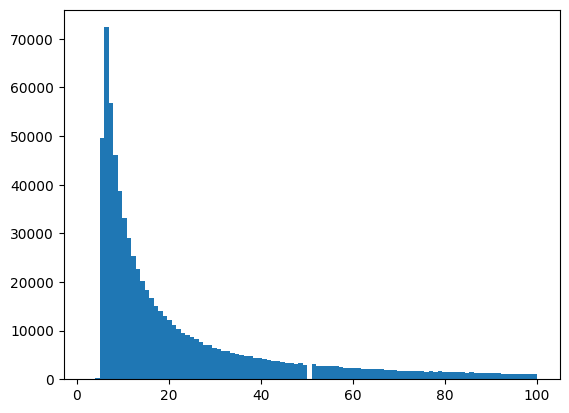

In [41]:
plt.hist(tracks.query('count <= 100')['count'], bins=100)


In [37]:
import seaborn as sns

Text(0.5, 0, 'Tracks')

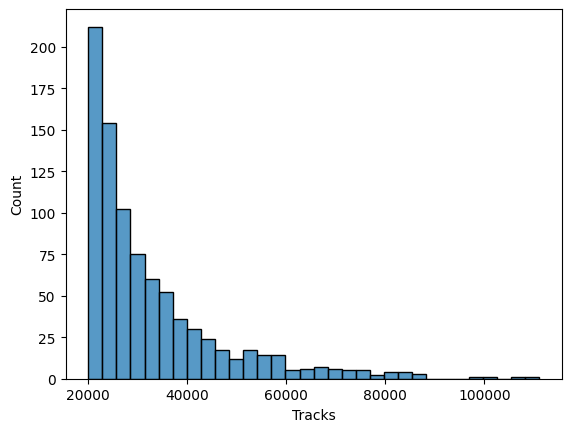

In [39]:
sns.histplot(tracks.query('count >= 20000')['count'].fillna(0))
plt.xlabel('Tracks')

Наиболее популярные треки

In [44]:
tracks[['track_id','count','name']].sort_values(by='count', ascending=False).head(10)
catalog_tracks = catalog_tracks.merge(tracks[['count','track_id']], left_on='id', right_on='track_id')
catalog_tracks.drop(columns=['track_id'], inplace=True)


In [46]:
catalog_tracks.sort_values('count', ascending=False).head(10)

id                     name  count_x  count_y   count
8215       53404  Smells Like Teen Spirit   111062   111062  111062
451664  33311009                 Believer   106921   106921  106921
24433     178529                     Numb   101924   101924  101924
478765  35505245               I Got Love    99490    99490   99490
774169  65851540                   Юность    86670    86670   86670
341295  24692821           Way Down We Go    86246    86246   86246
443347  32947997             Shape of You    85886    85886   85886
651810  51241318               In The End    85244    85244   85244
83809     795836        Shape Of My Heart    85042    85042   85042
607542  45499814                     Life    84748    84748   84748

/tmp/ipykernel_219026/1451962387.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(


[Text(0, 0, 'Smells Like Teen Spirit'),
 Text(1, 0, 'Believer'),
 Text(2, 0, 'Numb'),
 Text(3, 0, 'I Got Love'),
 Text(4, 0, 'Юность'),
 Text(5, 0, 'Way Down We Go'),
 Text(6, 0, 'Shape of You'),
 Text(7, 0, 'In The End'),
 Text(8, 0, 'Shape Of My Heart'),
 Text(9, 0, 'Life')]

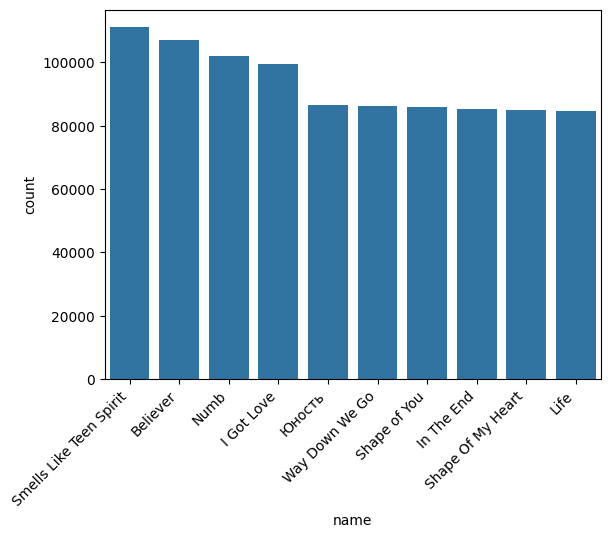

In [56]:
p = sns.barplot(catalog_tracks.sort_values('count', ascending=False).head(10),x='name', y='count')
p.set_xticklabels(
    p.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right'
)

In [50]:
catalog_tracks.to_parquet('../data/catalog_tracks.parquet')

(array([ 148201.,  192358.,  172134.,  268240.,  311700.,  262459.,
         387518.,  431634.,  351026.,  505503.,  549948.,  442020.,
         624725.,  498827.,  702108.,  747713.,  592265.,  826998.,
         870964.,  683504.,  950577.,  996923.,  777570., 1074763.,
         839507., 1157846., 1207839.,  936417., 1289020., 1340665.,
        1036658., 1425276., 1475006., 1139436., 1561318., 1614665.,
        1241160., 1698673., 1311020., 1790139., 1842043., 1414538.,
        1933496., 1989027., 1527155., 2081109., 2138155., 1637404.,
        2233059., 1708755., 2324778., 2387956., 1824282., 2481403.,
        2542194., 1945960., 2644429., 2704845., 2068454., 2809762.,
        2873336., 2195813., 2983642., 2278917., 3093772., 3158010.,
        2408102., 3269353., 3334345., 2545551., 3454690., 3520903.,
        2685108., 3640694., 2771240., 3751363., 3817447., 2906555.,
        3933520., 3998960., 3035922., 4105882., 4164647., 3159655.,
        4261388., 4319254., 3273782., 4400208., 

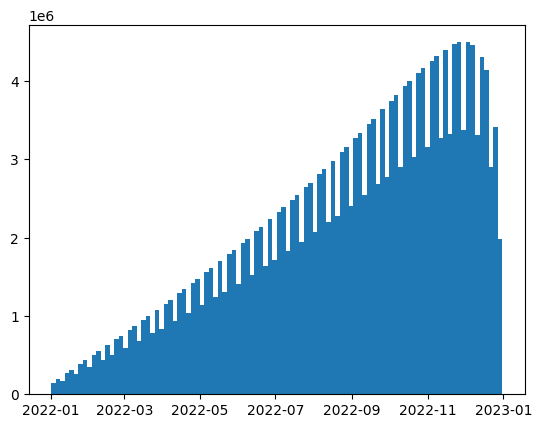

In [65]:
plt.hist(interactions['started_at'], bins=100)

Наиболее популярные жанры

In [52]:
catalog_genres = pd.read_parquet('../data/catalog_genres.parquet')
catalog_genres.sort_values('count', ascending=False).head(10)

id         name   count
11    11          pop  166109
75    75          rap  128206
102  102      allrock  118461
68    68  electronics  106478
3      3       rusrap   65958
44    44   foreignrap   59772
14    14         rock   55148
16    16        dance   51595
20    20       ruspop   46706
13    13  alternative   42894

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

Следует перезапустить kernel, выполнять действия начиная с 3го этапа

### ВЫВОДЫ:

Больше всего треков, которые слушают менее 20 раз. Вероятно, их можно убрать из выборки для существенного сокращения размера (делать мы это конечно же не будем)

Треки из топ-10 находятся в моем сердечке :)

Топ жанров возглавляет поп, рэп, рок и электроника, остальные идут с большим отрывом в полтора-два раза по количеству треков

# === ЭТАП 3 ===

# Загрузка данных

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy
import sklearn.preprocessing
from catboost import CatBoostClassifier, Pool

In [4]:
items = pd.read_parquet('../data/items.parquet')
interactions = pd.read_parquet('../data/events.parquet')
#catalog = pd.read_parquet('data/catalog_names.parquet')

In [6]:
catalog_genres = pd.read_parquet('../data/catalog_genres.parquet')
catalog_albums = pd.read_parquet('../data/catalog_albums.parquet')
catalog_artists = pd.read_parquet('../data/catalog_artists.parquet')
catalog_tracks = pd.read_parquet('../data/catalog_tracks.parquet')

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [7]:
train_test_global_time_split_date = pd.to_datetime("2022-12-16")
interactions_train = interactions.loc[interactions["started_at"] < train_test_global_time_split_date]
interactions_test = interactions.loc[interactions["started_at"] >= train_test_global_time_split_date]



In [ ]:

# В учебных целях берем 25% от всего, потому что иначе все выполняется бессовестно долго. 
interactions_train = interactions_train.sample(frac=0.25, random_state = 42)

In [9]:
print(interactions_train.shape)
print(interactions_test.shape)

(50299870, 4)
(13514936, 4)


In [ ]:
# Drop items in test that are not in train
interactions_test = interactions_test.loc[~interactions_test['track_id'].isin(items_diff)]
print(interactions_test.shape)

(13438773, 4)


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [10]:
item_popularity = interactions_train.groupby('track_id')[['user_id']].count().reset_index().sort_values(by='user_id', ascending=False)[:100]
item_popularity.columns = ['track_id', 'count']
item_popularity

track_id  count
7920       53404  27471
23491     178529  25393
427095  33311009  25232
452692  35505245  23657
323047  24692821  21052
...          ...    ...
747958  68562711  11949
793610  75642961  11884
794783  75944934  11797
8394       57730  11691
746648  68348389  11651

[100 rows x 2 columns]

In [11]:
item_popularity['rank'] = item_popularity['count'].rank(ascending=False)
item_popularity['rank'] = item_popularity['rank'].astype(int)
item_popularity = item_popularity.rename(columns= {'track_id': 'item_id'})

In [ ]:
item_popularity.to_parquet('../recommendations/top_popular.parquet')


In [15]:
item_popularity = pd.read_parquet('../recommendations/top_popular.parquet')

In [16]:
item_popularity

item_id  count  rank
7920       53404  27471     1
23491     178529  25393     2
427095  33311009  25232     3
452692  35505245  23657     4
323047  24692821  21052     5
...          ...    ...   ...
747958  68562711  11949    96
793610  75642961  11884    97
794783  75944934  11797    98
8394       57730  11691    99
746648  68348389  11651   100

[100 rows x 3 columns]

# Персональные

Рассчитаем персональные рекомендации.

In [17]:
interactions_train['target'] = 1 # Факт прослушивания
interactions_test['target'] = 1 # Факт прослушивания

/tmp/ipykernel_155402/3672207653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions_test['target'] = 1 # Факт прослушивания


## ALS

In [18]:
user_encoder = sklearn.preprocessing.LabelEncoder()

# перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder.fit(interactions["user_id"])
interactions_train["user_id_enc"] = user_encoder.transform(interactions_train["user_id"])
interactions_test["user_id_enc"] = user_encoder.transform(interactions_test["user_id"])

# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["track_id"])
items["track_id_enc"] = item_encoder.transform(items["track_id"])
interactions_train["track_id_enc"] = item_encoder.transform(interactions_train["track_id"])
interactions_test["track_id_enc"] = item_encoder.transform(interactions_test["track_id"])

/tmp/ipykernel_155402/3892860961.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions_test["user_id_enc"] = user_encoder.transform(interactions_test["user_id"])
/tmp/ipykernel_155402/3892860961.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions_test["track_id_enc"] = item_encoder.transform(interactions_test["track_id"])


In [22]:
interactions_train


user_id  track_id  track_seq started_at  target  user_id_enc  \
273  1311288  65891271        274 2022-12-03       1      1305663   
241  1182663  35112957        242 2022-10-16       1      1177607   
134   785243  89084998        135 2022-12-14       1       781869   
14    172914     43117         15 2022-06-08       1       172180   
20    572275  20003416         21 2022-12-08       1       569812   
..       ...       ...        ...        ...     ...          ...   
621  1056259   2189518        622 2022-03-15       1      1051720   
382   278471  23344068        383 2022-04-02       1       277280   
136   682319  59373715        137 2022-11-11       1       679358   
5     955372   9548591          6 2022-08-05       1       951241   
896   689124  27759885        897 2022-06-25       1       686139   

     track_id_enc  
273        774484  
241        473510  
134        899346  
14           6832  
20         285162  
..            ...  
621        111587  
382        321471  
136        721033  
5          196517  
896        376419  

[50299870 rows x 7 columns]

CSR matrix

https://matteding.github.io/images/csr.gif

In [19]:
user_item_matrix_train = scipy.sparse.csr_matrix((
    interactions_train["target"],
    (interactions_train['user_id_enc'], interactions_train['track_id_enc'])),
    dtype=np.int8) 

In [20]:
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(factors=30, iterations=30, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train) 

/home/andrey/work/institute/MLE/assets/recsys/.venv_recsys/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/andrey/work/institute/MLE/assets/recsys/.venv_recsys/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 30/30 [02:48<00:00,  5.61s/it]


In [ ]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=False, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items = not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

In [83]:
user_id = interactions_train['user_id'].sample().iat[0]

print(f"user_id: {user_id}")

print("История (последние события)")
user_history = (
    interactions_train
    .query("user_id == @user_id")
    .merge(items.set_index("track_id")[["name", "genres"]], on="track_id")
)
user_history_to_print = user_history.tail(10)
display(user_history_to_print)


user_id: 39211
История (последние события)


user_id  track_id  track_seq started_at  target  user_id_enc  \
56    39211  33977439        143 2022-11-14       1        39046   
57    39211  15410295         89 2022-11-03       1        39046   
58    39211  14293633         85 2022-11-03       1        39046   
59    39211  37100370        156 2022-11-16       1        39046   
60    39211  32043093        133 2022-11-11       1        39046   
61    39211    878664         37 2022-10-24       1        39046   
62    39211  67464959        282 2022-12-11       1        39046   
63    39211  21998692        108 2022-11-07       1        39046   
64    39211  62793881        267 2022-12-07       1        39046   
65    39211   1710808         47 2022-10-26       1        39046   

    track_id_enc                                               name  \
56        459580                                      Feel It Still   
57        229667                               Танцуй, пока молодая   
58        219139                                       Trebles 2013   
59        502447                                         Белая ночь   
60        428825                                    Mr. Vain Recall   
61         89718  Y Si No Existieras (Y Si No Has De Volver) (Et...   
62        784874                                           Побуяним   
63        313896                     Don't Think I Will Forgive You   
64        748758                                          Kanyelele   
65        103882                                  Bohemian Rhapsody   

               genres  
56               [70]  
57           [11, 20]  
58               [16]  
59           [11, 20]  
60               [16]  
61              [325]  
62           [11, 20]  
63               [68]  
64               [68]  
65  [14, 17, 25, 102]

In [84]:
print("Рекомендации")
user_recommendations_als = get_recommendations_als(user_item_matrix_train, als_model, user_id, user_encoder, item_encoder, include_seen=True)
user_recommendations_als = user_recommendations_als.merge(items.set_index("track_id")[["name", "genres"]], left_on="item_id", right_on="track_id")

display(user_recommendations_als)

Рекомендации


item_id_enc     score   item_id             name    genres
0       774169  0.511178  65851540           Юность  [11, 20]
1       534847  0.254975  39257277       In My Mind      [16]
2       443347  0.238578  32947997     Shape of You      [11]
3       663491  0.184026  52380688          Любимка  [11, 20]
4       728275  0.179992  60292250  Blinding Lights      [74]

In [ ]:
# !!! 45 minutes 
# чтобы не ждать - переместиться на строку считывания parquet

# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_)-1)

# получаем рекомендации для всех по+льзователей 


als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=30)

In [ ]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [ ]:
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]


In [ ]:
als_recommendations = als_recommendations.sort_values(by = "score", ascending=False)
als_recommendations.to_parquet("recsys/recomendations/personal_als.parquet") 

In [43]:
als_recommendations = pd.read_parquet("../recommendations/personal_als.parquet")

# Похожие

In [ ]:

# !!!! 40 minutes
# чтобы не ждать - переместиться на строку считывания parquet

# получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = interactions_train['track_id_enc'].unique()

max_similar_items = 10

# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше


similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "track_id_enc": train_item_ids_enc,
    "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()})
similar_items = similar_items.sort_values('score')


In [ ]:
# Надо бы сделать обратную трансформацию, но зависает спустя несколько часов работы.... Пока будем считать, что энкодед это истиные идентификаторы 
# similar_items["item_id"] = similar_items['track_id_enc'].apply(lambda x: item_encoder.inverse_transform([x])[0])
# similar_items["sim_item_id"] = similar_items['sim_item_id_enc'].apply(lambda x: item_encoder.inverse_transform(x[1:]))


Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [77]:
similar_items.rename(columns={'track_id_enc':'item_id', 'sim_item_id_enc':'sim_item_id'}, inplace=True)
similar_items.to_parquet("../recommendations/similar_items.parquet")

In [78]:
similar_items = pd.read_parquet("../recommendations/similar_items.parquet")

In [79]:
similar_items

item_id                       sim_item_id  \
787744   440450  [440450, 794964, 662906, 789388]   
89069    478024  [478024, 542933, 200580, 501613]   
142892   170948   [170948, 357991, 184016, 56267]   
636868   178504   [178504, 92743, 206733, 337648]   
694565   429070  [429070, 428326, 289784, 428323]   
...         ...                               ...   
750870   752554  [752554, 511740, 397649, 718404]   
393268   346630  [346651, 346630, 346622, 346616]   
559345   346651  [346651, 346630, 346622, 346616]   
476378   346616  [346651, 346630, 346622, 346616]   
500411   346622  [346651, 346630, 346622, 346616]   

                                                    score  
787744  [0.9999995231628418, 0.8756284713745117, 0.841...  
89069   [0.9999995231628418, 0.950843870639801, 0.9462...  
142892  [0.9999995231628418, 0.9587958455085754, 0.956...  
636868  [0.9999995231628418, 0.9872869849205017, 0.986...  
694565  [0.9999995827674866, 0.8366211652755737, 0.836...  
...                                                   ...  
750870  [1.0000004768371582, 1.0000003576278687, 0.972...  
393268  [1.0000004768371582, 1.0000004768371582, 1.000...  
559345  [1.0000004768371582, 1.0000004768371582, 1.000...  
476378  [1.0000004768371582, 1.0000004768371582, 1.000...  
500411  [1.0000004768371582, 1.0000004768371582, 1.000...  

[873606 rows x 3 columns]